In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from prophet import Prophet
import itertools
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_excel('Unificado_def_2015_2025.xlsx')

**API - Header y configuración Token para hacer peticiones**




In [ ]:
df

,datetime_utc,geo_id,geo_name,value
0,2014-12-31T23:00:00Z,8741,Península,25459
1,2014-12-31T23:10:00Z,8741,Península,25591
2,2014-12-31T23:20:00Z,8741,Península,25531
3,2014-12-31T23:30:00Z,8741,Península,25453
4,2014-12-31T23:40:00Z,8741,Península,25329
...,...,...,...,...
692580,2025-04-12T16:00:00Z,8741,Península,23274
692581,2025-04-12T16:05:00Z,8741,Península,23627
692582,2025-04-12T16:10:00Z,8741,Península,23741
692583,2025-04-12T16:15:00Z,8741,Península,23749


In [ ]:
df = pd.read_excel("/content/Unificado_def_2015_2025.xlsx") #Cargamos los datos defintivos todos juntos

In [ ]:
data = df[['datetime_utc', 'value']]

In [ ]:
data = data.rename(columns={'datetime_utc': 'datetime'})


In [ ]:
data['datetime_str'] = pd.to_datetime(data['datetime']).dt.tz_localize(None).dt.strftime('%Y-%m-%d %H:%M:%S')


In [ ]:
data = data[['value', 'datetime_str']]

In [ ]:
data = data.rename(columns={'datetime_str': 'datetime'})


In [ ]:
#Quitamos la zona horario que no nos va a hacer falta
data['datetime'] = data['datetime'].astype(str)
data['datetime'] = data['datetime'].str.split('+').str[0]
data['datetime'] = pd.to_datetime(data['datetime'])

[0]	validation_0-rmse:4467.33036	validation_1-rmse:4240.31984
[50]	validation_0-rmse:1265.63941	validation_1-rmse:1238.31705
[100]	validation_0-rmse:673.43414	validation_1-rmse:666.21443
[150]	validation_0-rmse:569.18104	validation_1-rmse:576.36351
[200]	validation_0-rmse:527.26112	validation_1-rmse:551.76625
[250]	validation_0-rmse:505.84434	validation_1-rmse:540.64676
[299]	validation_0-rmse:492.33209	validation_1-rmse:534.10803


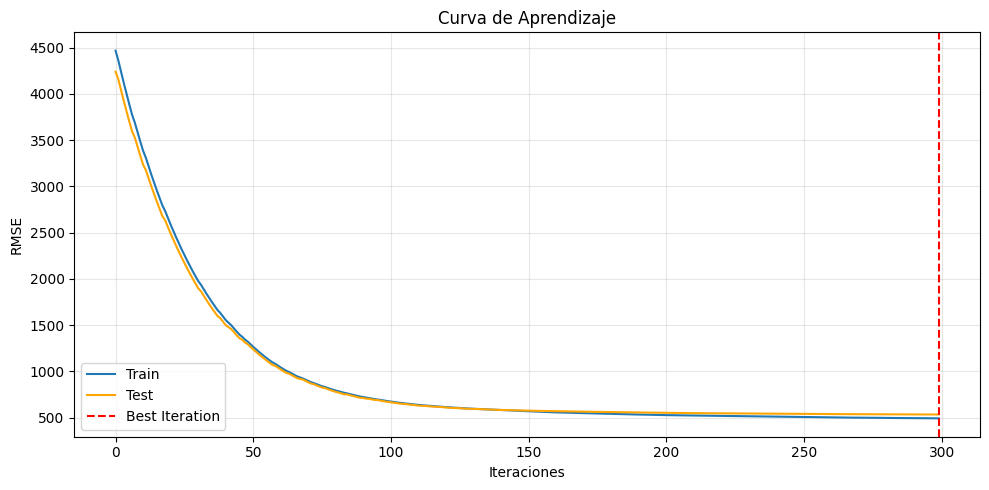

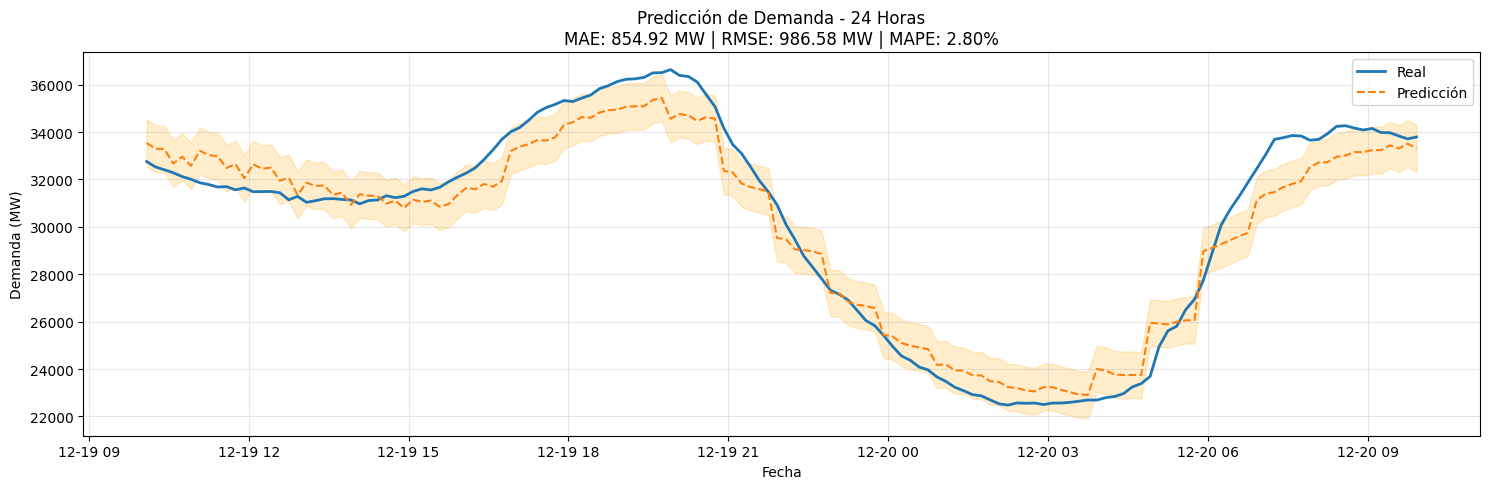

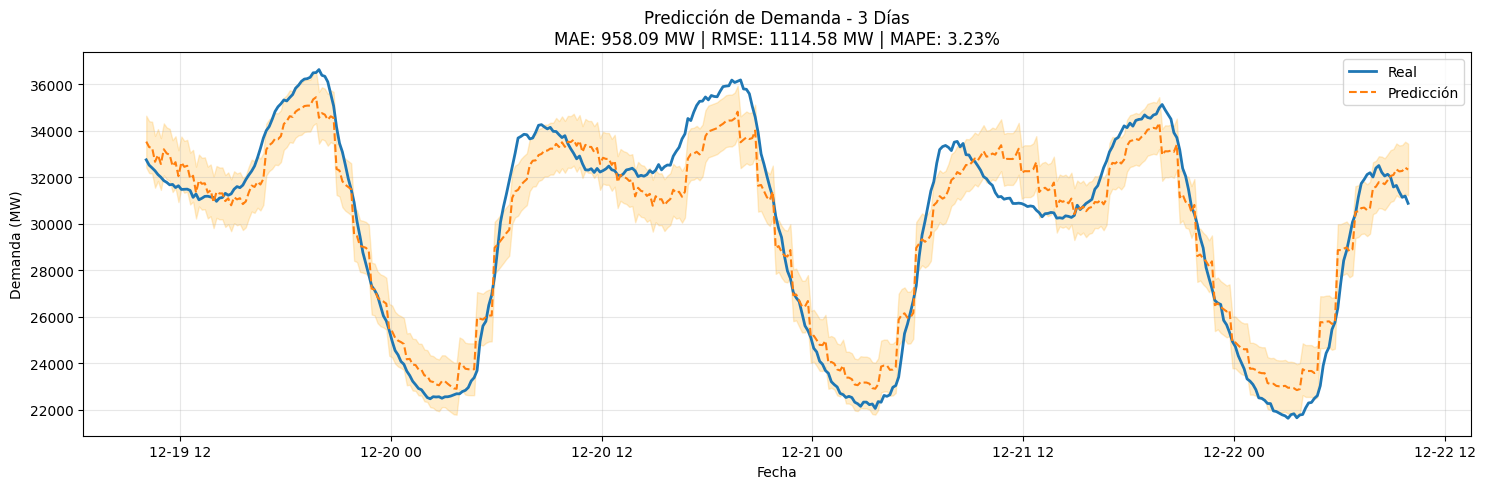

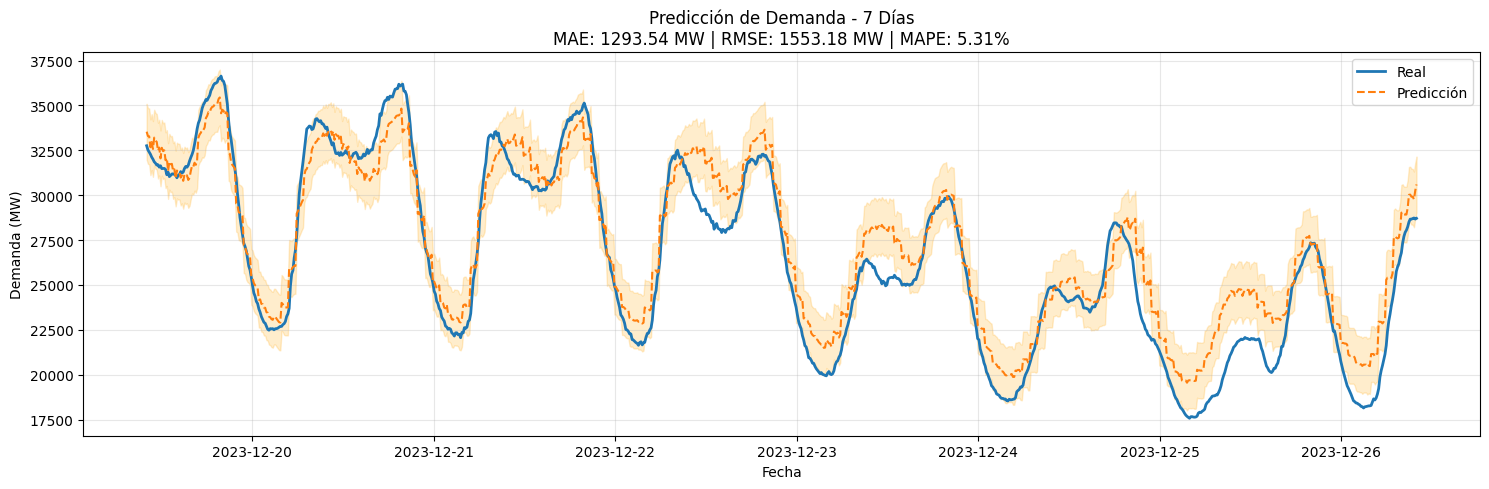

['scaler_optimizado.pkl']

In [ ]:

import pandas as pd
import numpy as np
import holidays
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

df = data.copy()
df = df.set_index('datetime').sort_index()
df = df.rename(columns={'value': 'demanda_mw'})[['demanda_mw']]


def crear_caracteristicas(df):
    df = df.copy()
    df['hora'] = df.index.hour
    df['dia_semana'] = df.index.dayofweek
    df['dia_mes'] = df.index.day
    df['mes'] = df.index.month
    df['festivo'] = df.index.normalize().isin(holidays.ES(years=range(2015,2026))).astype(int)
    df['fin_semana'] = (df['dia_semana'] >= 5).astype(int)
    df['hora_sin'] = np.sin(2 * np.pi * df['hora']/24)
    df['hora_cos'] = np.cos(2 * np.pi * df['hora']/24)
    df['dia_semana_sin'] = np.sin(2 * np.pi * df['dia_semana']/7)
    df['dia_semana_cos'] = np.cos(2 * np.pi * df['dia_semana']/7)
    for lag in [6, 144, 1008]:
        df[f'lag_{lag}'] = df['demanda_mw'].shift(lag).ffill()
    df['hora_x_fin_semana'] = df['hora'] * df['fin_semana']
    return df.dropna()

df_completo = crear_caracteristicas(df)


split_idx = int(len(df_completo) * 0.8)
df_train = df_completo.iloc[:split_idx]
df_test = df_completo.iloc[split_idx:]

X_train = df_train.drop(columns=['demanda_mw'])
y_train = df_train['demanda_mw']
X_test = df_test.drop(columns=['demanda_mw'])
y_test = df_test['demanda_mw']

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


modelo = XGBRegressor(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    n_jobs=-1,
    early_stopping_rounds=10,
    reg_alpha=0.5,
    reg_lambda=1.0
)

modelo.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    verbose=50
)


resultados = modelo.evals_result()
plt.figure(figsize=(10, 5))
plt.plot(resultados['validation_0']['rmse'], label='Train')
plt.plot(resultados['validation_1']['rmse'], label='Test', color='orange')
plt.axvline(modelo.best_iteration, color='red', linestyle='--', label='Best Iteration')
plt.title('Curva de Aprendizaje')
plt.xlabel('Iteraciones')
plt.ylabel('RMSE')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


def predecir_horizonte(fecha_inicio, pasos):
    inicio = pd.Timestamp(fecha_inicio)
    datos_iniciales = df_completo.loc[:inicio].last('7D')
    predicciones = []
    current_data = datos_iniciales.copy()

    for _ in range(pasos):
        nueva_fecha = current_data.index[-1] + pd.Timedelta(minutes=10)
        nueva_fila = pd.DataFrame(index=[nueva_fecha])

        nueva_fila['hora'] = nueva_fecha.hour
        nueva_fila['dia_semana'] = nueva_fecha.dayofweek
        nueva_fila['dia_mes'] = nueva_fecha.day
        nueva_fila['mes'] = nueva_fecha.month
        nueva_fila['hora_sin'] = np.sin(2 * np.pi * nueva_fecha.hour/24)
        nueva_fila['hora_cos'] = np.cos(2 * np.pi * nueva_fecha.hour/24)
        nueva_fila['dia_semana_sin'] = np.sin(2 * np.pi * nueva_fecha.dayofweek/7)
        nueva_fila['dia_semana_cos'] = np.cos(2 * np.pi * nueva_fecha.dayofweek/7)
        for lag in [6, 144, 1008]:
            lag_time = nueva_fecha - pd.Timedelta(minutes=10*lag)
            nueva_fila[f'lag_{lag}'] = current_data['demanda_mw'].get(lag_time, np.nan)

        nueva_fila['festivo'] = int(nueva_fecha.date() in holidays.ES())
        nueva_fila['fin_semana'] = int(nueva_fecha.dayofweek >= 5)
        nueva_fila['hora_x_fin_semana'] = nueva_fila['hora'] * nueva_fila['fin_semana']

        X_pred = nueva_fila.reindex(columns=X_train.columns).fillna(0)
        X_pred_scaled = scaler.transform(X_pred)
        pred = modelo.predict(X_pred_scaled)[0]
        predicciones.append(pred)
        current_data.loc[nueva_fecha] = [pred] + list(X_pred.iloc[0])

    return pd.Series(predicciones, index=pd.date_range(start=fecha_inicio, periods=pasos, freq='10T'))

def graficar_prediccion(real, pred, titulo):
    plt.figure(figsize=(15, 5))
    real = real.reindex(pred.index)
    mae = mean_absolute_error(real.dropna(), pred.dropna())
    rmse = np.sqrt(mean_squared_error(real.dropna(), pred.dropna()))
    mape = mean_absolute_percentage_error(real.dropna(), pred.dropna()) * 100

    plt.plot(real, label='Real', color='#1f77b4', linewidth=2)
    plt.plot(pred, label='Predicción', color='#ff7f0e', linestyle='--')
    plt.fill_between(pred.index, pred - rmse, pred + rmse, color='orange', alpha=0.2)
    plt.title(f"{titulo}\nMAE: {mae:.2f} MW | RMSE: {rmse:.2f} MW | MAPE: {mape:.2f}%")
    plt.xlabel('Fecha')
    plt.ylabel('Demanda (MW)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def evaluar_multiples_horizontes(df, df_completo, modelo, scaler, X_train, fecha_inicio):
    pasos_dict = {
        '24 Horas': 144,
        '3 Días': 432,
        '7 Días': 1008
    }
    for nombre, pasos in pasos_dict.items():
        pred = predecir_horizonte(fecha_inicio, pasos)
        real = df['demanda_mw'].reindex(pred.index)
        graficar_prediccion(real, pred, f"Predicción de Demanda - {nombre}")

fecha_inicio_pred = df_test.index[0].strftime('%Y-%m-%d %H:%M:%S')
evaluar_multiples_horizontes(df, df_completo, modelo, scaler, X_train, fecha_inicio_pred)

joblib.dump(modelo, 'modelo_xgboost_optimizado.pkl')
joblib.dump(scaler, 'scaler_optimizado.pkl')


**Análisis de Patrones y Estacionalidad**
